# Code for Ice-Cube 3D CNN
Using Wahid's tutorial keras code on ICE-Cube CNN data.
- October 5, 2018: 2D CNN works.
- October 6, 2018: got simple 3D CNN to work.
- Oct 10, 2018: Changes made:
    - Using cross validation and shuffling arguments of the fit function.
- Oct 16, 2018: Reading in actual data, which is very large. Saving to files. Split code into 2 parts: process data and train. Putting back shuffle and test options.
- Oct 18, 2018: This notebook does the entire workflow (except processing raw data) for 4 different models, in modular way, without classes.
The data formatting is still not modular.
- Oct 22, 2018: Saving model and history to project space. history files are 12GB!

In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import glob
import pickle
import time

In [2]:
# %matplotlib widget
%matplotlib inline

Useful blog for keras conv3D: http://learnandshare645.blogspot.com/2016/06/3d-cnn-in-keras-action-recognition.html

In [3]:
# keras modules
import keras
from keras import layers, models, optimizers, callbacks  # or tensorflow.keras as keras
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import load_model



Using TensorFlow backend.


### Steps:
- Data processing
    - Read raw data
    - Process data
    - Save process data
    - Read processed data
- Model
    - Define model
    - Train model
    - Validate model
    - Plot accuracy and loss
    - Save model
- Test
    - Read model
    - Read training data
    - Get weights
    - Test model
    - Plot ROC curve


### Process data 
#### Get data from the .hdf5 files. This takes a long time. Do this only once.



Run this is in bash

%%bash
conda activate v_python2
cd extract_data
python process_data.py
conda deactivate


## Modules

### Extracting data

In [4]:
# Load data from files
def f_load_data():
    ''' Load raw data from files
    '''
    data_dir='/global/project/projectdirs/dasrepo/vpa/ice_cube/data_for_cnn/extracted_data_v/extract_data/'
    f1='processed_input_x'
    f2='processed_input_y'
    inpx=np.load(data_dir+f1+'.npy')
    inpy=np.load(data_dir+f2+'.npy')
    print(inpx.shape,inpy.shape)
    return inpx,inpy


### Format data


In [5]:
#### Shuffle and split data ####

def f_shuffle_data(inpx,inpy):
    ## Shuffle data
    
    # Setting seed
    seed=243
    np.random.seed(seed=seed)

    ## Get shuffled array of indices
    shuffle_arr=np.arange(inpx.shape[0])
    np.random.shuffle(shuffle_arr)
    inpx=inpx[shuffle_arr]
    inpy=inpy[shuffle_arr]

    return inpx,inpy

def f_drop_data(inpx,inpy,data_size):
    # Drop data for quick training.
    
    full_size=inpy.shape[0]
    assert(data_size<=full_size),"data_size: %s in f_drop_data is more than full data size: %s"%(data_size,full_size)
        
    temp=inpx[:data_size]
    del(inpx)
    inpx=temp.copy()
    temp=inpy[:data_size]
    del(inpy)
    inpy=temp.copy()
    del(temp)    
    return (inpx,inpy)        
        
       

def f_split_data(inpx,inpy,test_fraction):
    '''
    Split data for training and test. validation from training piece of data.
    !! Warning this code deletes inpx,inpy inside the function. can't help it because the arrays are too big!!
    '''
    
    num=inpx.shape[0]
    test_idx=int(test_fraction*num)
    train_idx=num-test_idx

    train_x=inpx[:train_idx]
    train_y=inpy[:train_idx]
    
    test_x=inpx[train_idx:]
    test_y=inpy[train_idx:]

    return train_x,train_y,test_x,test_y


def f_format_data(inpx,inpy,shuffle_flag=True,drop_data=True,data_size=1000,test_fraction=0.25):
    ''' Shuffle, drop and split data for train-test
    '''
    # Shuffle data
    if shuffle_flag: inpx,inpy=f_shuffle_data(inpx,inpy)
    # Drop data
    if drop_data: inpx,inpy=f_drop_data(inpx,inpy,data_size)

#     print(inpy[inpy==0.0].shape,inpy[inpy>0.0].shape,inpy.shape)
    
#     # Plot data
#     plt.figure()
#     plt.plot(inpy[:],linestyle='',marker='*',markersize=1)
#     plt.title("Plot of y data after shuffle")
#     plt.show() 
    
    # Split data into train-test.
    train_x,train_y,test_x,test_y=f_split_data(inpx,inpy,test_fraction)
    
    print('Data sizes: train_x{0},train_y{1},test_x{2},test_y{3}'.format(train_x.shape,train_y.shape,test_x.shape,test_y.shape))
    
    return train_x,train_y,test_x,test_y

    

### Model details

In [6]:
### Defining all the models tried in the study

def f_define_model(inpx,name):
    '''
    Function that defines the model and compiles it.
    '''
    
    inputs = layers.Input(shape=inpx.shape[1:])
    h = inputs
    
    # Choose model
    if name=='1':
        print("model %s"%name)
        # Convolutional layers
        conv_sizes=[10, 10, 10]
        conv_args = dict(kernel_size=(3, 3, 3), activation='relu', padding='same')
        for conv_size in conv_sizes:
            h = layers.Conv3D(conv_size, **conv_args)(h)
            h = layers.MaxPooling3D(pool_size=(2, 2, 2))(h)
    #         h = layers.Dropout(0.5)(h)
        h = layers.Flatten()(h)

        # Fully connected  layers
        h = layers.Dense(10, activation='relu')(h)
        #    h = layers.Dropout(0.5)(h)

        # Ouptut layer
        outputs = layers.Dense(1, activation='sigmoid')(h)
    
    
    elif name=='2':
        print("model %s"%name)
        # Convolutional layers
        conv_sizes=[10,10,10]
        conv_args = dict(kernel_size=(3, 3, 3), activation='relu', padding='same')
        for conv_size in conv_sizes:
            h = layers.Conv3D(conv_size, **conv_args)(h)
            h = layers.MaxPooling3D(pool_size=(2, 2, 2))(h)
            h = layers.Dropout(0.5)(h)
        h = layers.Flatten()(h)

        # Fully connected  layers
        h = layers.Dense(64, activation='relu')(h)
        h = layers.Dropout(0.5)(h)

        # Ouptut layer
        outputs = layers.Dense(1, activation='sigmoid')(h)
        
    elif name=='3':
        print("model %s"%name)
        # Convolutional layers
        conv_sizes=[6,6,6]
        conv_args = dict(kernel_size=(3, 3, 3), activation='relu', padding='same')
        for conv_size in conv_sizes:
            h = layers.Conv3D(conv_size, **conv_args)(h)
            h = layers.MaxPooling3D(pool_size=(2, 2, 2))(h)
            h = layers.Dropout(0.5)(h)
        h = layers.Flatten()(h)

        # Fully connected  layers
        h = layers.Dense(64, activation='relu')(h)
        h = layers.Dropout(0.5)(h)

        # Ouptut layer
        outputs = layers.Dense(1, activation='sigmoid')(h)
    
    elif name=='4':
        print("model %s"%name)
        # Convolutional layers
        conv_sizes=[6,6,6]
        conv_args = dict(kernel_size=(3, 3, 3), activation='relu', padding='same')
        for conv_size in conv_sizes:
            h = layers.Conv3D(conv_size, **conv_args)(h)
            h = layers.MaxPooling3D(pool_size=(2, 2, 2))(h)
            h = layers.Dropout(0.5)(h)
        h = layers.Flatten()(h)

        # Fully connected  layers
        h = layers.Dense(120, activation='relu')(h)
        h = layers.Dropout(0.5)(h)

        # Ouptut layer
        outputs = layers.Dense(1, activation='sigmoid')(h)
        
    elif name=='5':
        print("model %s"%name)
        # Convolutional layers
        conv_sizes=[6,6]
        conv_args = dict(kernel_size=(3, 3, 3), activation='relu', padding='same')
        for conv_size in conv_sizes:
            h = layers.Conv3D(conv_size, **conv_args)(h)
            h = layers.MaxPooling3D(pool_size=(3, 3, 3))(h)
            h = layers.Dropout(0.5)(h)
        h = layers.Flatten()(h)

        # Fully connected  layers
        h = layers.Dense(120, activation='relu')(h)
        h = layers.Dropout(0.5)(h)

        # Ouptut layer
        outputs = layers.Dense(1, activation='sigmoid')(h)
        
    
    ############################################
    ####### Compile model ######################
    ############################################
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
#     model.summary()

    return model


### Train and perform fit

In [14]:

def f_train_model(model,inpx,inpy):
    
    # Train model and get history
    history=model.fit(x=inpx, y=inpy,
                    batch_size=32,
                    epochs=5,
                    verbose=1,
#                     callbacks = [callbacks.ModelCheckpoint('./rpv_weights.h5')],
                    validation_split=0.33,
                    shuffle=True
                )
    
    print("Number of parameters",model.count_params())
    return history


def f_test_model(xdata,ydata,model):
    ## Test model and make ROC plot
    y_pred=model.predict(xdata,verbose=1)
#     print(y_pred)
    fpr,tpr,threshold=roc_curve(ydata,y_pred)
    print(fpr.shape,tpr.shape,threshold.shape)
    f_roc_curve(fpr,tpr)


    

def f_plot_learning(history):
    
    plt.figure()
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'],label='Train')
    plt.plot(history.history['val_acc'],label='Validation')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure()
    plt.plot(history.history['loss'],label='Train')
    plt.plot(history.history['val_loss'],label='Validation')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

def f_roc_curve(fpr,tpr):
    '''
    Module for roc plot and printing AUC
    '''
    plt.figure()
    # plt.plot(fpr,tpr)
    plt.scatter(fpr,tpr)
    plt.show()

    
    # AUC 
    auc_val = auc(fpr, tpr)
    print("AUC: ",auc_val)
    

    

def f_perform_fit(train_,train_y,test_x,test_y,model_dict,train_status=False):
    '''
    Compile, train, save and test the model.
    Steps:
    - Compile
    - Train
    - Save
    - Read
    - Plot
    - Test
    '''
    
    model_save_dir='/global/project/projectdirs/dasrepo/vpa/ice_cube/data_for_cnn/saved_models/'
    model_name=model_dict['name'] # string for the model
    fname_model,fname_history='model_{0}.h5'.format(model_name),'history_{0}.pickle'.format(model_name)
    
    if not train_status: # If not trained before, start to train the model

        ########################
        # Compile model
        model=f_define_model(train_x,model_name)
        # Train model
        history=f_train_model(model,train_x,train_y)

        ########################
        # Save model and history
        model.save(model_save_dir+fname_model)
        with open(model_save_dir+fname_history, 'wb') as f:
                pickle.dump(history, f)
    
    else:
        print("Using trained model")

        
    ########################
    ### Read model and history
    
    ### Check if files exist
    assert os.path.exists(model_save_dir+fname_model),"Model not saved"
    assert os.path.exists(model_save_dir+fname_history),"History not saved"
    
    model=load_model(model_save_dir+fname_model)
    with open(model_save_dir+fname_history,'rb') as f:
        history= pickle.load(f)
    
    ########################
    model.summary()
    # Plot tested model
    f_plot_learning(history)
    
    ########################
    # Test model
    f_test_model(test_x,test_y,model)
      
    model_dict['model'],model_dict['history']=model,history

    
    return model_dict

## Execution starts

### Get Data

In [8]:
# ##Extract data
inpx,inpy=f_load_data()
# print(sys.getsizeof(inpx))

# ##Format data
train_x,train_y,test_x,test_y=f_format_data(inpx,inpy,shuffle_flag=True,drop_data=False,data_size=10000,test_fraction=0.25)


((136066, 10, 20, 60, 1), (136066,))
Data sizes: train_x(102050, 10, 20, 60, 1),train_y(102050,),test_x(34016, 10, 20, 60, 1),test_y(34016,)


### Model 1

Using trained model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 20, 60, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 20, 60, 10)    280       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 10, 30, 10)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 10, 30, 10)     2710      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 5, 15, 10)      0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 5, 15, 10)      2710      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 2, 7, 10)       0

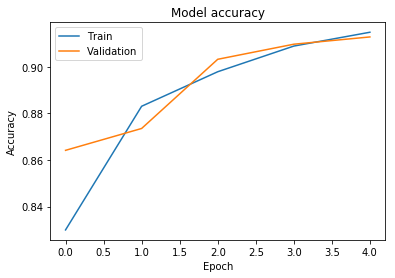

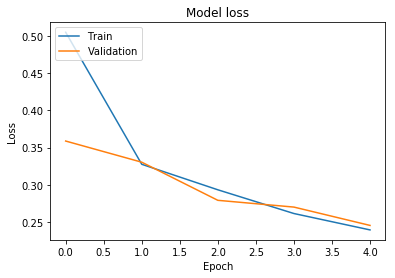

34016/34016 [==============================] - 75s 2ms/step
((4479,), (4479,), (4479,))


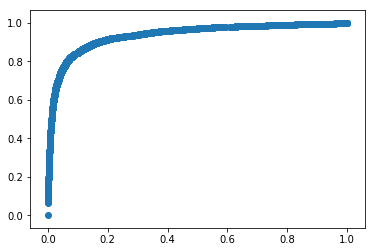

('AUC: ', 0.9368554084027532)


In [9]:
train_status=True
# train_status=False

model_dict={'name':'1','description':'simplest','model':None,'history':None}
model_dict1=f_perform_fit(train_x,train_y,test_x,test_y,model_dict,train_status)


### Model 2

Using trained model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 20, 60, 1)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 20, 60, 10)    280       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 5, 10, 30, 10)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 10, 30, 10)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 5, 10, 30, 10)     2710      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 2, 5, 15, 10)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 5, 15, 10)      0

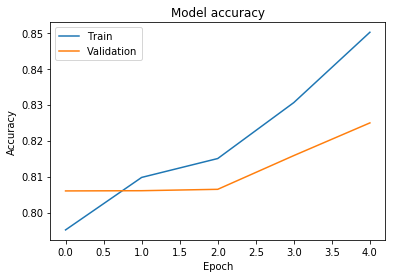

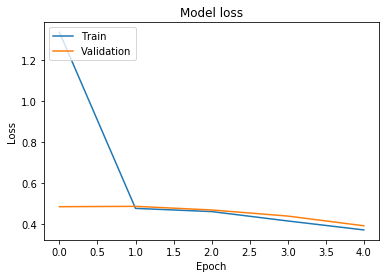

34016/34016 [==============================] - 76s 2ms/step
((6093,), (6093,), (6093,))


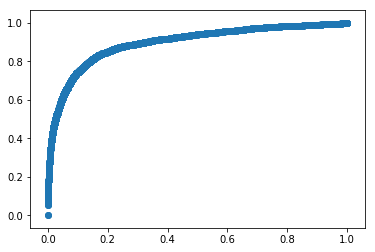

('AUC: ', 0.8965769000099703)


In [15]:
train_status=True
# train_status=False

model_dict={'name':'2','description':'simplest','model':None,'history':None}
model_dict2=f_perform_fit(train_x,train_y,test_x,test_y,model_dict,train_status)


### Model 3

In [ ]:
# train_status=True
train_status=False

model_dict={'name':'3','description':'6conv size, extra dropout','model':None,'history':None}
model_dict3=f_perform_fit(train_x,train_y,test_x,test_y,model_dict,train_status)


### Model 4

In [ ]:
# train_status=True
train_status=False

model_dict={'name':'4','description':'6conv size, extra dropout','model':None,'history':None}
model_dict4=f_perform_fit(train_x,train_y,test_x,test_y,model_dict,train_status)



### Model 5

In [ ]:
# train_status=True
train_status=False

model_dict={'name':'4','description':'6conv size, extra dropout','model':None,'history':None}
model_dict4=f_perform_fit(train_x,train_y,test_x,test_y,model_dict,train_status)




### Comparing models

In [ ]:
### Comparing different models:

for num,md in enumerate([model_dict1,model_dict2,model_dict3,model_dict4,model_dict]):
    hist=md['history'].history
    print('Model %s'%(num+1))
    for key in hist.keys():
        print(key,hist[key])
        

### Re-plot

In [ ]:
# # Re-plot
# m=model_dict1
# f_plot_learning(m['history'])
# f_test_model(test_x,test_y,m['model'])

## -----------------------------------------------

### Questions:
- Why are fpr and tpr different for 2 different models?


In [ ]:
# ## Gather Nick's data
# def f_read_file(fname):
# #     print(os.path.isfile(fname),os.path.exists(fname))

#     with open(fname,'rb') as f:
#         X, y, weights, event_id, filenames = pickle.load(f)

#     print(X.shape,y.shape,filenames[0])
#     return X,y,weights,event_id,filenames

# data_dir='/global/project/projectdirs/dasrepo/vpa/project/ice_cube/data_for_cnn/nick_choma_files/'
# for i in ['train.pickle','val.pickle','test.pickle']:
#     f_read_file(data_dir+i)
# X,y,weights,event_id,filenames=f_read_file(data_dir+'train.pickle')

#### Notes:
- model.fit 
    - batch_size= sample of data used for training (subset of full training set). 
    - epoch= number of runs over training data
    - callbacks=
    
- for layers.Input need size (x,y,z,1) in channels_last mode.

### To do:
- Try deleting inpx,inpy to save memory.
- Get weights for reserved data.
- Understand the Roc curve code and roc_auc_score